In [1]:
import sys
import os
import shutil
import numpy as np

# Move two upper directories, import benchmark, revert cwd
sys.path.append("../..")
import cmdbench
sys.path.pop()

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

strain_name = "2014C-3598"

In [2]:
def rem_if_exists(path):
    if os.path.exists(path):
        if(os.path.isfile(path)):
            os.remove(path)
        else:
            shutil.rmtree(path)
def get_last_n_lines(string, n):
    return "\n".join(string.split("\n")[-n:])

In [3]:
# Remove mccortex output file if it exists
rem_if_exists("%s_1.ctx" % strain_name)
# Remove mccortex output file if it exists
rem_if_exists("%s_2.ctx" % strain_name)
# Remove bloom filters if they exist
rem_if_exists("bloom-filters")
# Output after indexing 
rem_if_exists("test-berkeleydb")
rem_if_exists("test-berkeley.db")

# Delete indexed data
os.system("bigsi delete")

0

In [4]:
os.system("export BIGSI_CONFIG=berkleydb.yaml")

0

In [5]:
command_mccortex = "mccortex 17 build --nkmers 74000000 --threads 1 --kmer 17 --mem 20G --sample {0} --seq {0}.fastq.gz {0}.ctx"

# strain_1

command_mccortex_1 = command_mccortex.format(strain_name + "_1")
benchmark_results_mccortex_1 = cmdbench.benchmark_command(command_mccortex_1)

print(command_mccortex_1)
print(benchmark_results_mccortex_1.get_single_iteration())
print(get_last_n_lines(benchmark_results_mccortex_1.get_single_iteration().process.stderr_data, 10))

# strain_2

command_mccortex_2 = command_mccortex.format(strain_name + "_2")
benchmark_results_mccortex_2 = cmdbench.benchmark_command(command_mccortex_2)

print(command_mccortex_2)
print(benchmark_results_mccortex_2.get_single_iteration())
print(get_last_n_lines(benchmark_results_mccortex_2.get_single_iteration().process.stderr_data, 10))

mccortex 17 build --nkmers 74000000 --threads 1 --kmer 17 --mem 20G --sample 2014C-3598_1 --seq 2014C-3598_1.fastq.gz 2014C-3598_1.ctx
{
  'cpu': {
    'system_time': 0.17,
    'total_time': 0.38,
    'user_time': 0.21,
  },
  'disk': {
    'read_bytes': 0,
    'read_chars': 189080,
    'total_bytes': 2801664,
    'total_chars': 2990257,
    'write_bytes': 2801664,
    'write_chars': 2801177,
  },
  'memory': {
    'max': 838582272,
    'max_perprocess': 835219456,
  },
  'process': {
    'execution_time': 0.391,
    'stderr_data': '[03 Jun 2020 13:34:04-zAG][cmd]
                    /home/manzik/anaconda3/envs/bigsi_mccortex/bin/mccortex31
                    ...(52 hidden lines)',
    'stdout_data': '',
  },
  'time_series': {
    'cpu_percentages': array([0., 0., 0., ..., 0., 0., 0.])
    'memory_bytes': array([ 41848832,  63606784,  84975616, ..., 292311040,  93696000,
         3362816])
    'sample_milliseconds': array([  1,   8,  15, ..., 368, 375, 382])
  },
}

[03 Jun 2020 13:3

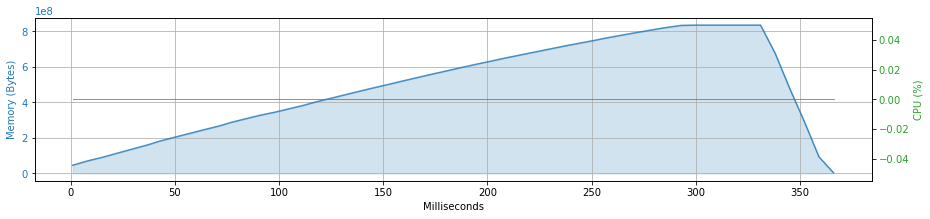

In [6]:
benchmark_results_mccortex_2.get_resources_plot()

In [7]:
command_bloom_filters = "bigsi bloom {0}.ctx bloom-filters/{0}.bloom"

# strain_1

command_bloom_filters_1 = command_bloom_filters.format(strain_name + "_1")
benchmark_results_bloom_filters_1 = cmdbench.benchmark_command(command_bloom_filters_1)

print(command_bloom_filters_1)
print(benchmark_results_bloom_filters_1.get_single_iteration())
print(get_last_n_lines(benchmark_results_bloom_filters_1.get_single_iteration().process.stdout_data, 10))

# strain_2

command_bloom_filters_2 = command_bloom_filters.format(strain_name + "_2")
benchmark_results_bloom_filters_2 = cmdbench.benchmark_command(command_bloom_filters_2)

print(command_bloom_filters_2)
print(benchmark_results_bloom_filters_2.get_single_iteration())
print(get_last_n_lines(benchmark_results_bloom_filters_2.get_single_iteration().process.stdout_data, 10))

bigsi bloom 2014C-3598_1.ctx bloom-filters/2014C-3598_1.bloom
{
  'cpu': {
    'system_time': 0.03,
    'total_time': 2.2899999999999996,
    'user_time': 2.26,
  },
  'disk': {
    'read_bytes': 0,
    'read_chars': 10238524,
    'total_bytes': 9252864,
    'total_chars': 19488531,
    'write_bytes': 9252864,
    'write_chars': 9250007,
  },
  'memory': {
    'max': 74162176,
    'max_perprocess': 74162176,
  },
  'process': {
    'execution_time': 2.295,
    'stderr_data': '',
    'stdout_data': '',
  },
  'time_series': {
    'cpu_percentages': array([  0. , 107.8,   0. , ...,   0. , 137.8, 142.3])
    'memory_bytes': array([ 9506816, 12480512, 15130624, ..., 45953024, 45953024, 45690880])
    'sample_milliseconds': array([   1,   10,   17, ..., 2271, 2278, 2285])
  },
}


bigsi bloom 2014C-3598_2.ctx bloom-filters/2014C-3598_2.bloom
{
  'cpu': {
    'system_time': 0.04,
    'total_time': 2.32,
    'user_time': 2.28,
  },
  'disk': {
    'read_bytes': 0,
    'read_chars': 10202462,


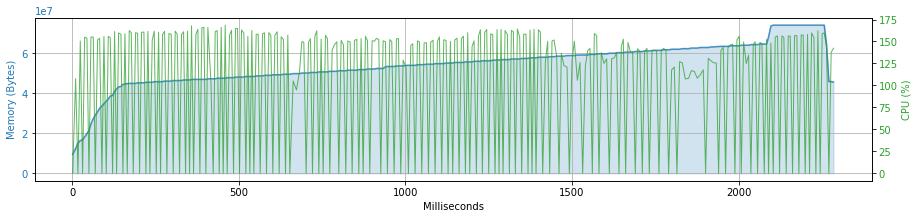

In [8]:
benchmark_results_bloom_filters_1.get_resources_plot()

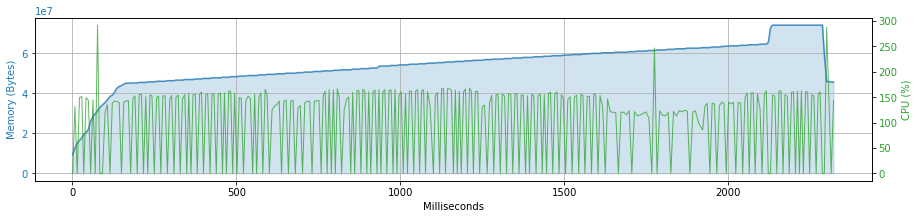

In [9]:
benchmark_results_bloom_filters_2.get_resources_plot()

In [10]:
# Index strain_1 and strain_2

command_index_bloom_filters = "bigsi build -b bloom-filters/{0}_1.bloom -b bloom-filters/{0}_2.bloom -s {0}_1 -s {0}_2 --config berkleydb.yaml".format(strain_name)
benchmark_results_index_bloom_filters = cmdbench.benchmark_command(command_index_bloom_filters)
print(command_index_bloom_filters)
print(benchmark_results_index_bloom_filters.get_single_iteration())
print(get_last_n_lines(benchmark_results_index_bloom_filters.get_single_iteration().process.stdout_data, 10))

bigsi build -b bloom-filters/2014C-3598_1.bloom -b bloom-filters/2014C-3598_2.bloom -s 2014C-3598_1 -s 2014C-3598_2 --config berkleydb.yaml
{
  'cpu': {
    'system_time': 207.67,
    'total_time': 449.92999999999995,
    'user_time': 242.26,
  },
  'disk': {
    'read_bytes': 0,
    'read_chars': 454338356171,
    'total_bytes': 25541046272,
    'total_chars': 908524025193,
    'write_bytes': 25541046272,
    'write_chars': 454185669022,
  },
  'memory': {
    'max': 330182656,
    'max_perprocess': 330182656,
  },
  'process': {
    'execution_time': 452.061,
    'stderr_data': 'INFO:bigsi.cmds.build:Building index:
                    0/1\n\nDEBUG:bigsi.cmds.build:Loading
                    ...(8 hidden lines)',
    'stdout_data': '{'result': 'success'}\n',
  },
  'time_series': {
    'cpu_percentages': array([  0. , 152.4, 159.1, ..., 150.9, 296.5,   0. ])
    'memory_bytes': array([ 9338880, 12251136, 14942208, ..., 64667648, 64405504,        0])
    'sample_milliseconds': array(

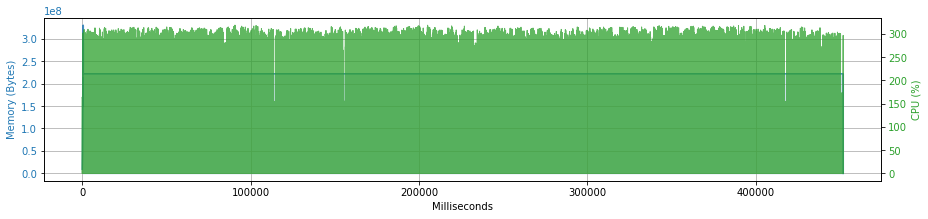

In [11]:
benchmark_results_index_bloom_filters.get_resources_plot()

In [12]:
# SEARCH

test_sequence = "GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACGGTGCAGAATCGTTGATCCCTAATCAGGCCTATCGC"
command_search = "bigsi search {0} --config berkleydb.yaml".format(test_sequence)
benchmark_results_search = cmdbench.benchmark_command(command_search)
print(command_search)
print(benchmark_results_search.get_single_iteration())
print(get_last_n_lines(benchmark_results_search.get_single_iteration().process.stdout_data, 100))

bigsi search GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACGGTGCAGAATCGTTGATCCCTAATCAGGCCTATCGC --config berkleydb.yaml
{
  'cpu': {
    'system_time': 0.01,
    'total_time': 0.18000000000000002,
    'user_time': 0.17,
  },
  'disk': {
    'read_bytes': 0,
    'read_chars': 7916070,
    'total_bytes': 0,
    'total_chars': 7916482,
    'write_bytes': 0,
    'write_chars': 412,
  },
  'memory': {
    'max': 46694400,
    'max_perprocess': 46694400,
  },
  'process': {
    'execution_time': 0.191,
    'stderr_data': '',
    'stdout_data': '{\n\n    "query": "GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCA
                    CCTTAAAATGGAATATGCCTTCTGGATGGACGGTGCAGAATCGTTGATCCCTAATCAGGC
                    ...(6 hidden lines)',
  },
  'time_series': {
    'cpu_percentages': array([  0. , 134.2,   0. , ...,   0. , 148.2, 143.6])
    'memory_bytes': array([ 9269248, 12189696, 14876672, ..., 46694400, 46694400, 46432256])
    'sample_milliseconds': array([  1,   8,  15, .

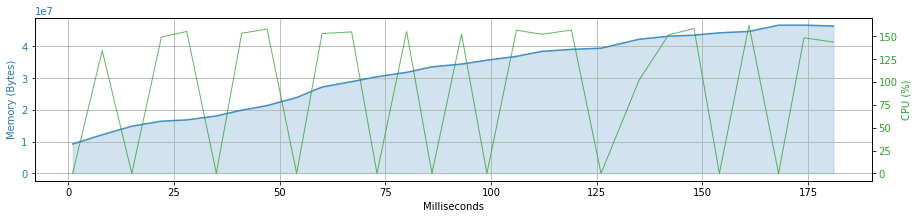

In [14]:
benchmark_results_search.get_resources_plot()